## Pyroomacousticsの紹介 ##

この記事はQiita Python Advent Calendar 2018の9日目の記事です。

### Pyroomacousticsとは ###

[Pyroomacoustics](https://github.com/LCAV/pyroomacoustics)は音響アレイ信号処理に関するアルゴリズムの迅速な開発や評価を目的としたライブラリです。ライブラリは主に下記の3つの要素から成り立っています。

* 2次元または3次元空間に配置された複数の音源と複数のマイクロホンに関するシミュレーション環境を迅速に構築するためのオブジェクト指向インタフェースの提供
* 一般的な多面体形状の室内に対して室内インパルス応答を効率的に生成するための鏡像法の高速なC実装と、音源と受音点の間の伝搬のシミュレーション環境の提供
* STFT, ビームフォーミング、方向推定(音源定位)、適応フィルタ、音源分離に対する一般的なアルゴリズムのリファレンス実装の提供

ここでは[デモ用notebook](https://github.com/LCAV/pyroomacoustics/blob/master/notebooks/pyroomacoustics_demo.ipynb)を参考に、使用方法や何ができるかについて説明していきます。
なおドキュメントはhttps://pyroomacoustics.readthedocs.io/en/pypi-release/index.html にあります。

### インストール方法 ###

pipで下記のようにインストールできます。また別途pipでcookiecutterをインストールしておくと、後述のようにpyroomacousitcs用のシミュレーションスクリプトを対話的に生成することが可能であるため便利です。

In [1]:
!pip install -U pyroomacoustics

Requirement already up-to-date: pyroomacoustics in /Users/wrist/.pyenv/versions/miniconda3-4.3.30/envs/py36/lib/python3.6/site-packages (0.1.20)


In [2]:
!pip install cookiecutter

### Pyroomacousitcsの使用方法 ###

まず下記ライブラリをインポートしておきます。

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra

### roomオブジェクトの生成 ###

下記のように2次元座標を要素に持つndarrayを作成し、pra.Room.from_cornersに与えることで2次元または3次元の室内空間を表すオブジェクトを生成することが可能です。またroomオブジェクトのplotメソッドで空間を描画することが可能です。座標の単位はmです。

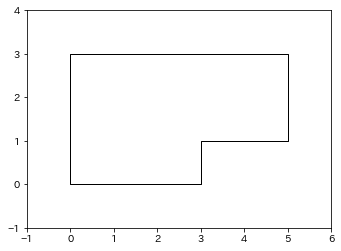

In [4]:
corners = np.array([[0,0], [0,3], [5,3], [5,1], [3,1], [3,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)

fig, ax = room.plot()
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 4]);

3次元空間については2次元空間をextrudeメソッドで指定した高さまで持ち上げます。

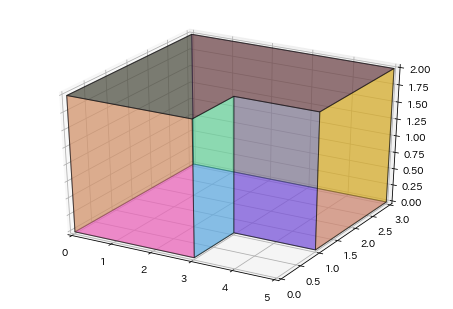

In [5]:
room = pra.Room.from_corners(corners)
room.extrude(2.)

fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])
ax.set_zlim([0, 2]);

なお、単純な正六面体の部屋であれば`ShoeBox`メソッドを使ったほうが早いです。

(0, 3)

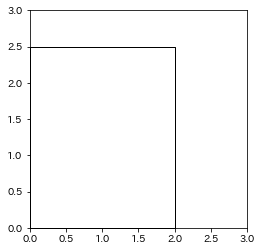

In [6]:
room = pra.ShoeBox([2.0, 2.5])
fig, ax = room.plot()
ax.set_xlim([0, 3])
ax.set_ylim([0, 3])

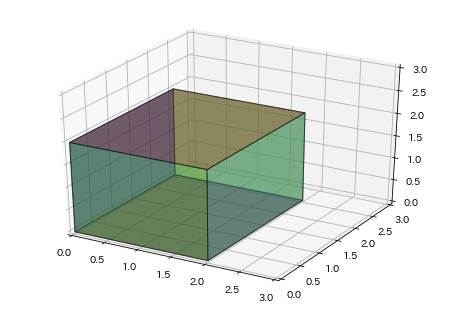

In [7]:
room = pra.ShoeBox([2.0, 2.5, 2.0])
fig, ax = room.plot()
ax.set_xlim([0, 3])
ax.set_ylim([0, 3])
ax.set_zlim([0, 3]);

### 音源とマイクロホンの追加 ###

roomオブジェクトに対してadd_sourceメソッドを用いることで指定した座標に音源を追加することが可能です。音源はndarrayである必要があるので、ここではscipy.ioのwavfileを用いて読み込んだ信号を用います

音源はデモ用ノートブックでは[CMU Arctic Database](http://www.festvox.org/cmu_arctic/)から取得した音声ファイルを用いています。
[ここ](http://festvox.org/cmu_arctic/cmu_arctic/packed/cmu_us_bdl_arctic-0.95-release.tar.bz2)からダウンロードしたtar.gzを解凍したその中のwavディレクトリに入っています。後で気づきましたが、pyroomacoustics自体が[データセットのラッパー](https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.datasets.html)も提供しています。

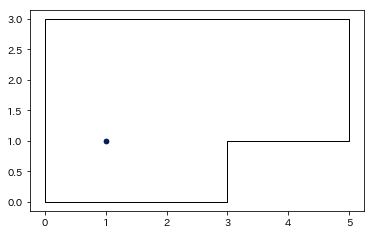

In [8]:
# specify signal source
fs, signal = wavfile.read("work/arctic_a0010.wav")

# add source to 2D room
room = pra.Room.from_corners(corners, fs=fs)
room.add_source([1.,1.], signal=signal)

fig, ax = room.plot()

黒点が音源位置を表しています。追加した音源はこんな感じです。

In [9]:
IPython.display.Audio(signal, rate=fs)

音源を追加した時点でroomオブジェクトにもfsが設定される模様です。試したところデフォルトでは8kHzが指定されているようでした。

In [10]:
room.fs

16000

この空間に更に環状のマイクロホンアレイを追加します。
ここではpra.circular_2D_arrayを用いて6素子からなる中心座標\[2.0, 2.0\]、半径0.1の環状アレイの各マイクロホンの座標を計算します。
各マイクロホンアレイの座標をfsとともにpra.MicrophoneArrayに渡すことでマイクロホンアレイオブジェクトを生成し、これをroomオブジェクトのadd_microphone_arrayメソッドにわたすことでマイクロホンアレイを室内空間へと追加します。

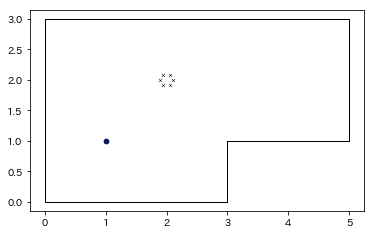

In [11]:
R = pra.circular_2D_array(center=[2.,2.], M=6, phi0=0, radius=0.1)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()

xがマイクロホンを表します。

### 鏡像法を用いた室内インパルス応答の生成 ###

音源とマイクロホンアレイが追加された室内では、音源が各マイクロホンへとどのように伝搬するかを表すインパルス応答を生成することができます。
ここではこのインパルス応答を鏡像法に基づいて生成します。
鏡像法とはざっくり言うと室内の壁面での反射波は壁面に対して音源と対象な位置に鏡像が存在すると考え、音源位置から放射された信号が壁面に伝達する度に鏡像を計算して、最終的には実音源とこれらの鏡像からマイクロホンへと到来する波の重ね合わせがマイクロホンにおける観測信号となるシミュレーション手法です。反射回数を何回まで考慮するかや、壁面での吸音率、取り扱うサンプリングレートなどによって鏡像法で推定されるインパルス応答の精度が変わってくることが知られています。

ここでは3次元の室内空間を生成し、\[1.0, 1.0, 0.5\]の位置に音源を追加、\[3.5, 2.0, 0.5\]と\[3.5, 2.0, 0.5\]の位置にマイクロホンアレイを追加します。
更に、roomオブジェクトの生成時に最大何次の反射までを考慮するかを表す`max_order`と壁面での反射時の吸音率を表す`absorption`が指定されています。max_orderが8であるため8次の反射までが考慮され、吸音率が0.2であるため反射率が0.8、すなわち壁面での反射時には音波が0.8倍されることを意味しています。

この状態でroomオブジェクトに対してimage_source_modelメソッドを呼ぶと、鏡像法に基づき室内の反射を模擬することが可能です。`use_libroom`のオプションは鏡像法のC実装を用いるかどうかを制御するオプションのようです。

なお、以下では3次反射までを描画しています。

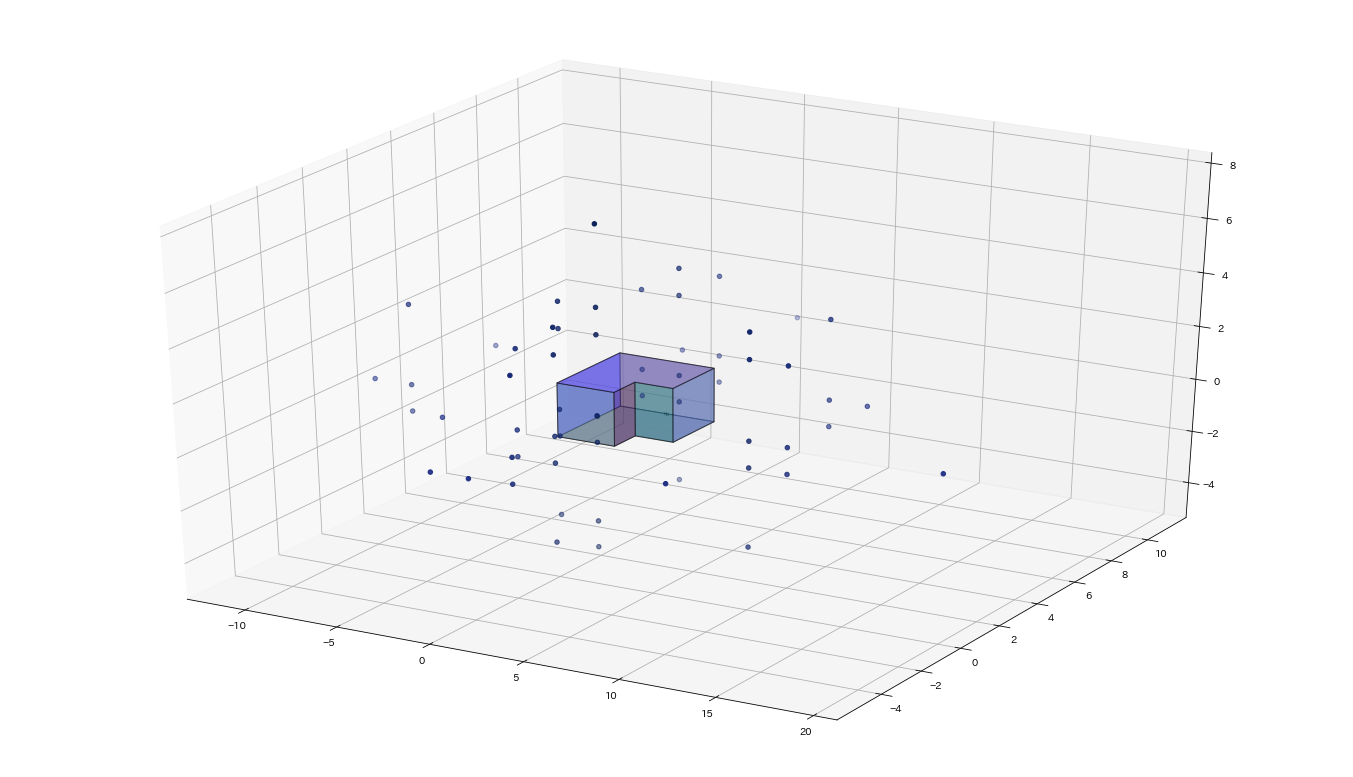

In [12]:
# specify signal source
fs, signal = wavfile.read("work/arctic_a0010.wav")

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=8, absorption=0.2)
room.extrude(2.)

# add source and set the signal to WAV file content
room.add_source([1., 1., 0.5], signal=signal)

# add two-microphone array
R = np.array([[3.5, 3.6], [2., 2.], [0.5,  0.5]])  # [[x], [y], [z]]
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

# compute image sources
room.image_source_model(use_libroom=True)

# visualize 3D polyhedron room and image sources
fig, ax = room.plot(img_order=3)
fig.set_size_inches(18.5, 10.5)

一度鏡像法のシミュレーションを実行すると、下記のように室内インパルス応答を描画することが可能になります。

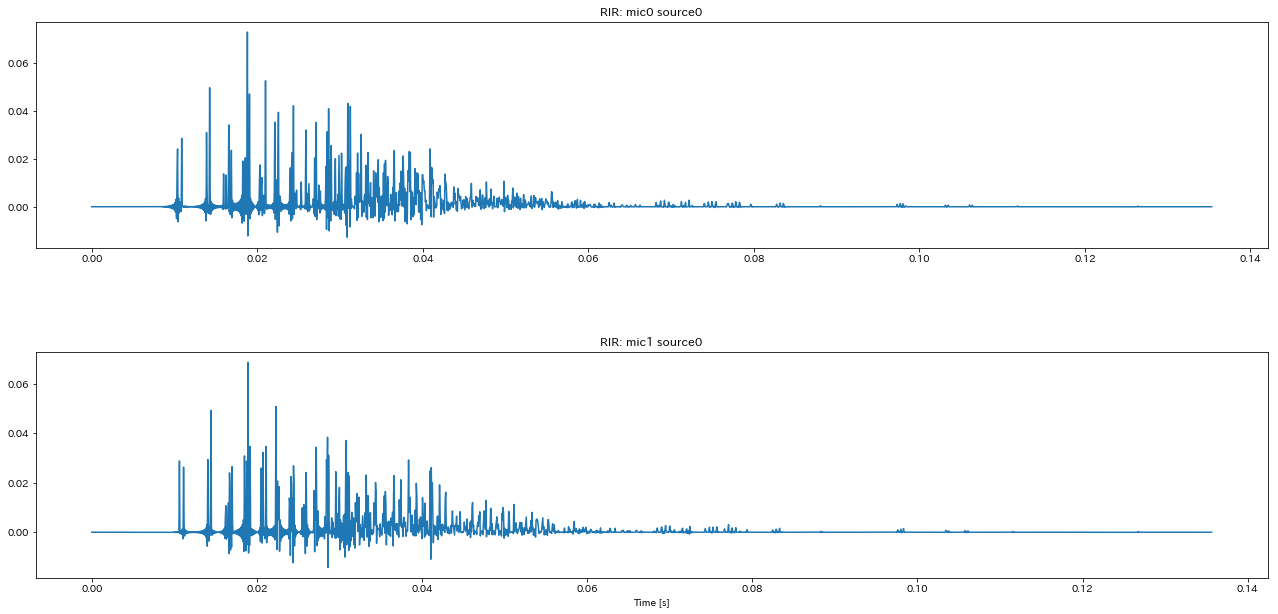

In [13]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

なおこの室内インパルス応答(RIR)はroomオブジェクトの下にrirとして格納されています。

In [14]:
room.rir

[[array([0., 0., 0., ..., 0., 0., 0.])],
 [array([0., 0., 0., ..., 0., 0., 0.])]]

pyroomacousticsではこの室内インパルス応答を音源に対して畳み込んだ場合のシミュレーションを行い、マイクロホンでの観測音源を生成することができます。
roomオブジェクトに対してsimulateメソッドを呼ぶことで、室内インパルス応答を畳み込んだ観測信号がroom.mic_array.signalsとして生成されます。ここではマイクロホンが2つ存在しているため、2つの観測信号が生成されています。

In [15]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 55372)


実際に聞いてみて元音源と比較することが可能です。

In [16]:
# original signal
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)

Original WAV:


In [17]:
print("Simulated propagation to first mic:")
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

Simulated propagation to first mic:


### cookiecutterを用いたシミュレーションスクリプトの雛形作成 ###

冒頭でpipでインストールしたcookiecutterを使うとここまでの内容を実行するためのシミュレーションスクリプトの雛形を下記のように対話的に作成することができます。
ここで`$`はシェルのプロンプトを表します。全質問に対して何も入力していないためデフォルトの項目(\[\]内の値)が選択されています。

    $ cookiecutter gh:fakufaku/cookiecutter-pyroomacoustics-sim
    You've downloaded /Users/wrist/.cookiecutters/cookiecutter-pyroomacoustics-sim before.
    Is it okay to delete and re-download it? [yes]:
    script_name [my_room_simulation]:
    samplerate [16000]:
    absorption [0.25]:
    max_order [17]:
    Select room_type:
    1 - shoebox
    2 - polygonal
    Choose from 1, 2 (1, 2) [1]:
    Select dimension:
    1 - 3D
    2 - 2D
    Choose from 1, 2 (1, 2) [1]:

これによって生成されたスクリプトの中身は下記のようになっています。

In [18]:
!cat work/my_room_simulation.py | pygmentize

import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt

# Simulation parameters
fs = 16000
absorption = 0.25
max_order = 17

# Geometry of the room and location of sources and microphones
room_dim = np.array([10, 7.5, 3])
source_loc = np.array([2.51, 3.57, 1.7])
mic_loc = np.c_[[7, 6.1, 1.3],[6.9, 6.1, 1.3]]

# Create the room itself
room = pra.ShoeBox(room_dim, fs=fs, absorption=absorption, max_order=max_order)

# Place a source of white noise playing for 5 s
source_signal = np.random.randn(fs * 5)
room.add_source(source_loc, signal=source_signal)

# Place the microphone array
room.add_microphone_array(
        pra.MicrophoneArray(mic_loc, fs=room.fs)
        )

# Now the setup is finished, run the simulation
room.simulate()

# As an example, we plot the simulated signals, the RIRs, and the room and a
# few images sources

# The microphone signal are in the rows of `room.mic_array.signals`
mic_signals = room.mic_array.signals
plt.figure()
plt.subplot(1,2,1)
p

音源として`np.random.randn`によるホワイトノイズが指定されていることが分かります。
これを実行すると下記のように観測信号、室内環境、室内インパルス応答がプロットされます。
分析の取っ掛かりに便利そうですね。

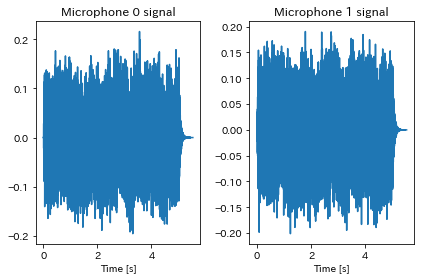

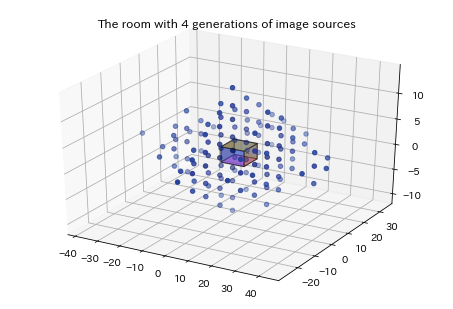

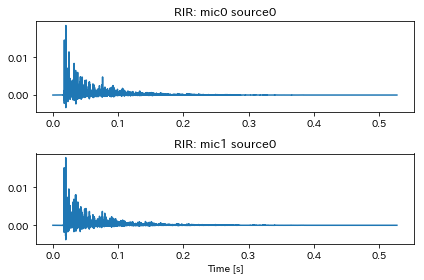

In [19]:
%run work/my_room_simulation.py

### ビームフォーミング ###

Pyroomacousticsはビームフォーミングのためのリファレンス実装を提供しています。
時間領域および周波数領域のどちらにおいても固定係数のビームフォーミングが使用可能です。
Pyroomacousticsが提供しているのは古典的な遅延和法(Delay and Sum;DAS)と最小分散法(MVDR)に基づくビームフォーマです。

下記では遅延和法を使用しています。
使用しているノイズはGoogleのSpeech Command datasetに含まれるものであり、datasetを解凍したディレクトリの`_background_noise_`ディレクトリ以下に入ってました。読み込みの際にwarningが出ますがコメントにある通り問題ないようですね。
音声信号を\[1, 4.5\]、妨害音(ノイズ)を\[3.5, 3\]の位置に配置し、マイクロホンアレイを\[2, 1.5\]位置を中心とした半径0.0375\[m\]=3.75\[cm\]の円周上および中心に配置しています。これはAmazon Echo相当の配置だとコメントに書いてありますね。ここではマイクの座標情報`echo`は`pra.MicrophoneArray`ではなく`pra.Beamformer`にfs, fft長、秒数で表されたフィルタサイズとともに渡しています。
このマイクオブジェクトをルームオブジェクト`room_bf`に`add_microphone_array`した上で、マイクロホンアレイオブジェクト`mics`の`rake_delay_and_sum_weights`を音源オブジェクト`room_bf.sources[0][:1]`を与えて呼ぶことで遅延和法の固定係数を計算しているようです。

/Users/wrist/.pyenv/versions/miniconda3-4.3.30/envs/py36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


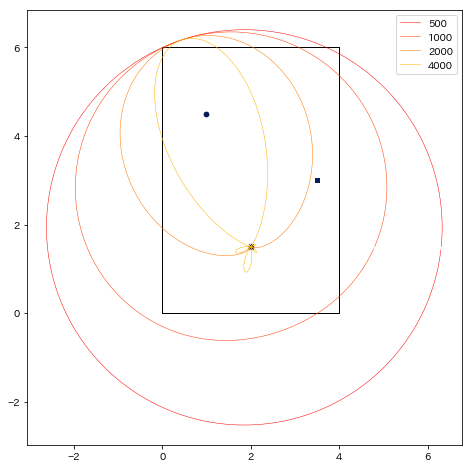

In [20]:
Lg_t = 0.100                # filter size in seconds
Lg = np.ceil(Lg_t*fs)       # in samples

# specify signal and noise source
fs, signal = wavfile.read("work/arctic_a0010.wav")
fs, noise = wavfile.read("work/exercise_bike.wav")  # may spit out a warning when reading but it's alright!

# Create 4x6 shoebox room with source and interferer and simulate
room_bf = pra.ShoeBox([4,6], fs=fs, max_order=12)
source = np.array([1, 4.5])
interferer = np.array([3.5, 3.])
room_bf.add_source(source, delay=0., signal=signal)
room_bf.add_source(interferer, delay=0., signal=noise[:len(signal)])

# Create geometry equivalent to Amazon Echo
center = [2, 1.5]; radius = 37.5e-3
fft_len = 512
echo = pra.circular_2D_array(center=center, M=6, phi0=0, radius=radius)
echo = np.concatenate((echo, np.array(center, ndmin=2).T), axis=1)
mics = pra.Beamformer(echo, room_bf.fs, N=fft_len, Lg=Lg)
room_bf.add_microphone_array(mics)

# Compute DAS weights
mics.rake_delay_and_sum_weights(room_bf.sources[0][:1])

# plot the room and resulting beamformer before simulation
fig, ax = room_bf.plot(freq=[500, 1000, 2000, 4000], img_order=0)
ax.legend(['500', '1000', '2000', '4000'])
fig.set_size_inches(20, 8)

`room_bf.plot`の引数にfreqを与えると周波数に応じたpolar patternも表示してくれるようです。
なお遅延和法で推定された固定係数は`mics.weights`に格納されているようです。

In [21]:
mics.weights.shape

(7, 257)

shapeが(7, 257)なので、マイクロホンアレイの7本のマイクそれぞれに対して257ptの固定係数、即ちFFT長/2+1個の周波数領域の係数が入っているようです。一般に遅延和法は音源方向から各マイクロホンへの到来時間が同一になるように遅延を補正して重畳させることで強調する手法なので、この固定係数は一定ゲインで位相差のみを制御するようなものになっていることが想像されます。

In [22]:
mics.weights

array([[ 3.58128812e-03+0.j        , -8.73334814e-04-0.00347317j,
        -3.15534434e-03+0.00169394j, ..., -3.46061631e-03-0.00092182j,
        -5.00866112e-05+0.00358094j,  3.48504461e-03-0.00082467j],
       [ 3.62330738e-03+0.j        , -8.09341157e-04-0.00353176j,
        -3.26174098e-03+0.00157778j, ..., -2.83947598e-03+0.00225072j,
         2.82810664e-03+0.00226499j,  1.57604295e-03-0.00326258j],
       [ 3.63718941e-03+0.j        , -7.88120007e-04-0.00355078j,
        -3.29564374e-03+0.00153879j, ..., -1.74332143e-03-0.00319217j,
        -2.73858467e-03+0.0023936j ,  2.93013528e-03+0.00215487j],
       ...,
       [ 3.56674207e-03+0.j        , -8.95397732e-04-0.00345252j,
        -3.11717936e-03+0.00173345j, ...,  1.82547501e-04+0.00356207j,
         3.40217087e-03-0.00107093j, -1.89071480e-03-0.00302438j],
       [ 3.55364827e-03+0.j        , -9.15215577e-04-0.00343377j,
        -3.08223439e-03+0.00176869j, ...,  3.49104208e-03-0.00066411j,
        -1.54079876e-03-0.00320224j

In [23]:
np.abs(mics.weights)

array([[0.00358129, 0.00358129, 0.00358129, ..., 0.00358129, 0.00358129,
        0.00358129],
       [0.00362331, 0.00362331, 0.00362331, ..., 0.00362331, 0.00362331,
        0.00362331],
       [0.00363719, 0.00363719, 0.00363719, ..., 0.00363719, 0.00363719,
        0.00363719],
       ...,
       [0.00356674, 0.00356674, 0.00356674, ..., 0.00356674, 0.00356674,
        0.00356674],
       [0.00355365, 0.00355365, 0.00355365, ..., 0.00355365, 0.00355365,
        0.00355365],
       [0.00359494, 0.00359494, 0.00359494, ..., 0.00359494, 0.00359494,
        0.00359494]])

In [24]:
np.angle(mics.weights)

array([[ 0.        , -1.8171409 ,  2.6489035 , ..., -2.88126198,
         1.58478242, -0.23235848],
       [ 0.        , -1.79606764,  2.69105004, ...,  2.47134787,
         0.67528024, -1.1207874 ],
       [ 0.        , -1.7892126 ,  2.70476011, ..., -2.07065847,
         2.42331424,  0.63410164],
       ...,
       [ 0.        , -1.82455165,  2.63408201, ...,  1.5195935 ,
        -0.30495815, -2.1295098 ],
       [ 0.        , -1.83127441,  2.6206365 , ..., -0.18798625,
        -2.01926066,  2.43265024],
       [ 0.        , -1.81023839,  2.66270853, ..., -1.12802278,
        -2.93826117,  1.53468576]])

上記のように各周波数ビンにおける振幅値は一定ですが、位相についてはビンごとに異なっていることが分かりました。

続いてこの室内において鏡像法により推定された室内インパルス応答を確認した上で、観測信号が遅延和法によってどのように変化したかを聞いてみます。

In [25]:
# RIRを計算
room_bf.compute_rir()
# 畳み込みを実行し観測信号を生成
room_bf.simulate()

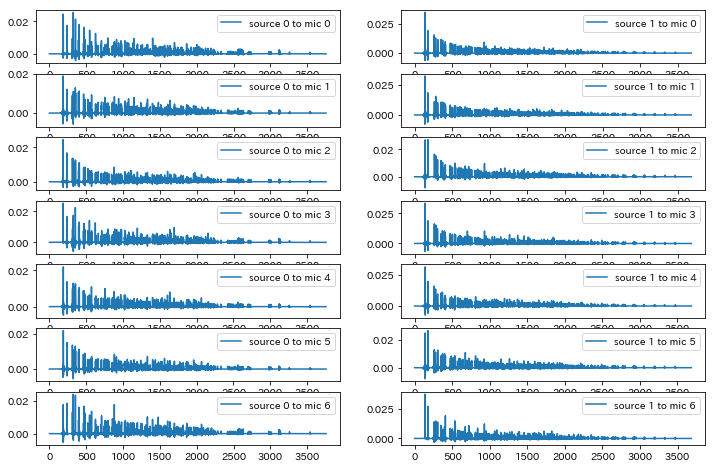

In [26]:
# room_bf.plot_rir()が見にくいので自分で描画
fig = plt.figure(1, figsize=(12,8))

for i, rir_s in enumerate(room_bf.rir):
    for j, rir in enumerate(rir_s):
        ax = fig.add_subplot(7, 2, 2*i + j + 1)
        ax.plot(rir,label="source {0} to mic {1}".format(j, i))
        ax.legend(loc=0)

In [27]:
print("Center Mic:")
IPython.display.Audio(room_bf.mic_array.signals[-1,:], rate=fs)  # -1はcenter mic

Center Mic:


In [28]:
signal_das = mics.process(FD=False)
print("DAS Beamformed Signal:")
IPython.display.Audio(signal_das, rate=fs)

DAS Beamformed Signal:


遅延和法による出力ではより鋭い指向性を持つ高域のノイズが顕著に抑圧されていることを確認できます。

### その他 ###

時間がなくなってしまったためここでは紹介しきれませんでしたが、pyroomacousticsには他にも音源定位、適応フィルタ、音源分離アルゴリズムのリファレンス実装が用意されています。これらについては改めて今後別の記事で紹介したいと思います。
特に音源分離アルゴリズムとして補助関数法を用いたIVAやILRMAといった最近のアルゴリズムが実装されている点が非常に熱いです。

### まとめ ###

室内形状から室内インパルス応答を算出しシミュレーションが可能なpyroomacousticsを紹介し、シミュレーションの実行方法とビームフォーミングの紹介を行いました。実際にインパルス応答を収録することなくシミュレーションを手軽に行うことができるため個人的にも非常に便利に使用できそうだと感じました。